# Examples and plots

## Imports

In [1]:
from utils import generate_problem_with_popularity
from serial_dictatorship import solve_SD
from optimization import PSSA
import matplotlib.pyplot as plt
import itertools
import numpy as np
import os
import random
from scipy import stats

## Definitions and functions

In [2]:
save_dir = r"../figures"

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
FIGSIZE = (6, 3.5)
COLORS = list(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [3]:
def generate_itermediate(iterable):
    """Utility for step plotting."""
    iterable = sorted(iterable)
    for a, b in zip(iterable, iterable[1:]):
        yield a
        x1, y1 = a
        x2, y2 = b
        yield x2, y1
    yield b

## Generate a random problem

In [4]:
import collections     
Student = collections.namedtuple("Student", ["id", "preferences", "grade_avg"])
School = collections.namedtuple("School", ["id", "capacity"])

In [5]:
num_students = 500
num_schools = 5


students, schools = generate_problem_with_popularity(num_students=num_students, 
                                                     num_schools=num_schools, 
                                                     capacity_ratio=1.0, 
                                                     num_choices=3, 
                                                     seed=1)

def cost_match(student, school):
    """Determine integer cost of a student-school assignment."""
    # Grades can also be used (from student.grade_avg), but are not used below

    # If the school is in the wishes
    student_pref = student.preferences.get(school.id)
    if student_pref is not None:
        return student_pref 
    else:
        return 4 # Cost of 4 for a school the student did not want

def multi_cost_func(x, cost_matrix, grades, capacities):
    """Compute a multi-objective cost of an assigment."""

    # Cost of priorities
    num_students, num_schools = x.shape
    cost_priorities = np.sum(x * cost_matrix) / num_students

    # Standard deviation of mean grades in each school
    mean_grades = [grades[np.arange(num_students)[x[:, i]]].mean() for i in range(num_schools)]
    std_grades = np.std(mean_grades, ddof=0)

    return min(cost_priorities, 1.55), std_grades * 100


## Solve the problem and plot solutions

Set up min-cost flow problem in 0.0039713382720947266 seconds.
Solved min-cost flow problem in 0.0010616779327392578 seconds.
Parsed min-cost flow solution in 0.0035102367401123047 seconds.
Main search iteration 1.
Main search iteration 2.
Main search iteration 3.
Main search iteration 4.
Main search iteration 5.
Main search iteration 6.
Main search iteration 7.
Main search iteration 8.
Main search iteration 9.


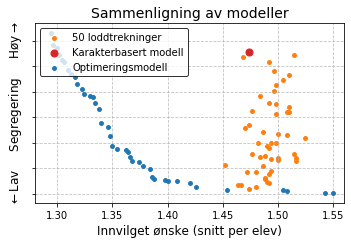

In [6]:


plt.figure(figsize=(5, 3.5))
plt.title(f"Sammenligning av modeller", fontsize=14)

lotteries = 50

# ========================================
# ========= LOTTERY SOLUTIONS ============
# ========================================

for seed in range(lotteries):
    
    random_generator = random.Random(seed)
    # Copy the students, but assign random numbers instead of actual grades
    students_lottery = [Student(s.id, s.preferences, random_generator.random()) for s in students]
    
    # Solve using serial dictatorship
    solution_dict = solve_SD(students_lottery, schools, cost_match_func=cost_match, verbose=0)
    
    # Get NumPy arrays to evaluate the multi-objective function
    x = PSSA.get_cost_matrix(students_lottery, schools, cost_match_func=cost_match)
    cost_matrix = PSSA.get_x_matrix(students_lottery, schools, solution_dict)
    grades = np.array([e.grade_avg for e in students_lottery])
    capacities = np.array([s.capacity for s in schools])
    
    (x_plt, y_plt) = multi_cost_func(x, cost_matrix, grades, capacities)
    
    if seed == 0:
        plt.scatter([x_plt], [y_plt], color=COLORS[1], label=f"{lotteries} loddtrekninger", zorder=10, s=15)
    else:
        plt.scatter([x_plt], [y_plt], color=COLORS[1], s=15)
    
    
    original_grades = [e.grade_avg for e in students]
    
# ========================================
# ========= GRADE BASED SOLUTIONS ========
# ========================================

# Solve using serial dictatorship
solution_dict = solve_SD(students, schools, cost_match_func=cost_match, verbose=0)

# Get NumPy arrays to evaluate the multi-objective function
x = PSSA.get_cost_matrix(students, schools, cost_match_func=cost_match)
cost_matrix = PSSA.get_x_matrix(students, schools, solution_dict)
grades = np.array([e.grade_avg for e in students])
capacities = np.array([s.capacity for s in schools])

(x_plt, y_plt) = multi_cost_func(x, cost_matrix, grades, capacities)
plt.scatter([x_plt], [y_plt], color=COLORS[3], label="Karakterbasert modell", zorder=10, s=50)


# ========================================
# ========= OPTIMIZATION =================
# ========================================

# Create the algorithm object
algorithm = PSSA(students, 
                 schools, 
                 cost_match_func=cost_match, 
                 multi_cost_func=multi_cost_func, 
                 max_frontier_size=40, 
                 verbose=1)

# The .solve() method is implemented as a generator, run X iterations:
for solutions in itertools.islice(algorithm.solve(), 10):
    pass

x = [x_objectives[0] for (_, x_objectives) in solutions]
y = [x_objectives[1] for (_, x_objectives) in solutions]

plt.scatter(x, y, label="Optimeringsmodell", zorder=12, s=15, color=COLORS[0])

# Area dominated by solutions
frontier_steps = list(generate_itermediate([x_objectives for (_, x_objectives) in solutions]))
#plt.plot([i for (i, j) in frontier_steps], 
#         [j for (i, j) in frontier_steps], "--", alpha=0.8,
#         zorder=99, color=COLORS[0])


plt.xlabel("Innvilget ønske (snitt per elev)", fontsize=12)
#plt.ylabel("Segregering\n$\\leftarrow$ Lav                 Høy $\\rightarrow$", fontsize=12)
plt.ylabel("$\\leftarrow$Lav     Segregering     Høy$\\rightarrow$", fontsize=12)
plt.xlim([1.28, 1.56])
#plt.ylim([-0.01, 0.17])
plt.legend(loc="upper left", edgecolor="k", fontsize=10).set_zorder(99)
plt.grid(True, ls="--", zorder=5, alpha=0.8)

frame1 = plt.gca()
frame1.axes.yaxis.set_ticklabels([])

plt.tight_layout()
plt.savefig(os.path.join(save_dir, f"sammenligning_modeller.png"), dpi=200)
plt.savefig(os.path.join(save_dir, f"sammenligning_modeller.pdf"))
plt.show()

## Weighted sampling

In [7]:
def generate_grade_averages(num_students, num_subjects, round_to=1, seed=2):
    np.random.seed(seed)
    grades = np.arange(1, 7)
    grade_probs = np.array([0.05, 0.15, 0.2, 0.3, 0.2, 0.1])

    # Clip a normal distribution
    grad_avgs = np.random.randn(num_students * 10) * 2.4 + 4
    grad_avgs = grad_avgs[(grad_avgs <= 6) & (grad_avgs >= 1.8)]
    grad_avgs = np.round(grad_avgs[:num_students], round_to)
    grad_avgs = np.sort(grad_avgs)
    return grad_avgs

def rank_students(grades):
    percentiles = stats.rankdata(grades, method='dense')
    percentiles = percentiles - np.min(percentiles)
    ans = percentiles / percentiles[-1]
    assert np.min(ans) == 0
    assert np.max(ans) == 1
    assert np.all(ans >= 0)
    assert np.all(ans <= 1)
    return ans

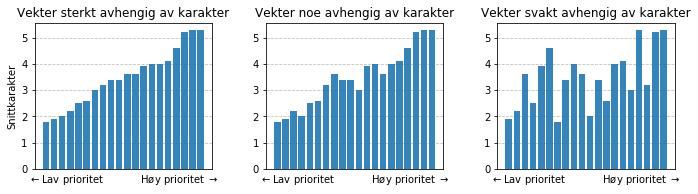

In [8]:
num_students = 20
num_subjects = 20

grad_avgs = generate_grade_averages(num_students, num_subjects)

# =============================================================================
plt.figure(figsize=(FIGSIZE[0]*1.65, FIGSIZE[1]*0.8))

plt.subplot(1, 3, 1)
plt.title(f"Vekter sterkt avhengig av karakter")

plt.bar(np.arange(num_students), grad_avgs, alpha=0.9, zorder=10)
plt.xticks([], [])
plt.grid(True, ls="--", zorder=5, alpha=0.8)
plt.xlabel(r"$\leftarrow$Lav prioritet" + r" "*12 + r"Høy prioritet $\rightarrow$")
plt.ylabel(r"Snittkarakter")

# =============================================================================
plt.subplot(1, 3, 2)
p = 15
plt.title(f"Vekter noe avhengig av karakter")
percentiles = rank_students(grad_avgs)
percentiles_transformed = np.exp(percentiles * p)
weights = np.log(np.random.rand(num_students)) /(percentiles_transformed)
sorted_inds = np.argsort(weights)
plt.bar(np.arange(num_students), grad_avgs[sorted_inds], alpha=0.9, zorder=10)
plt.xticks([], [])
plt.grid(True, ls="--", zorder=5, alpha=0.8)
plt.xlabel(r"$\leftarrow$Lav prioritet" + r" "*12 + r"Høy prioritet $\rightarrow$")

# =============================================================================
plt.subplot(1, 3, 3)
p = 1
plt.title(f"Vekter svakt avhengig av karakter")
percentiles = rank_students(grad_avgs)
percentiles_transformed = np.exp(percentiles * p) 
weights = np.log(np.random.rand(num_students)) /(percentiles_transformed)
sorted_inds = np.argsort(weights)
plt.bar(np.arange(num_students), grad_avgs[sorted_inds], alpha=0.9, zorder=10)
plt.xticks([], [])
plt.grid(True, ls="--", zorder=5, alpha=0.8)
plt.xlabel(r"$\leftarrow$Lav prioritet" + r" "*12 + r"Høy prioritet $\rightarrow$")

plt.tight_layout()
plt.savefig(os.path.join(save_dir, "vektet_loddtrekning.png"), dpi=200)
plt.show()


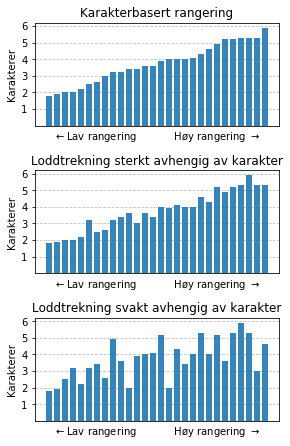

In [9]:
num_students = 28
num_subjects = 20

grad_avgs = generate_grade_averages(num_students, num_subjects)

# =============================================================================
plt.figure(figsize=(FIGSIZE[0]*0.7, FIGSIZE[1]*1.8))

plt.subplot(3, 1, 1)
plt.title(f"Karakterbasert rangering")

plt.bar(np.arange(num_students), grad_avgs, alpha=0.9, zorder=10)
plt.xticks([], [])
plt.yticks(np.arange(1, 7))
plt.grid(True, ls="--", zorder=5, alpha=0.8)
plt.xlabel(r"$\leftarrow$Lav rangering" + r" "*12 + r"Høy rangering $\rightarrow$")
plt.ylabel("Karakterer")

# =============================================================================
plt.subplot(3, 1, 2)
p = 20
plt.title(f"Loddtrekning sterkt avhengig av karakter")
percentiles = rank_students(grad_avgs)
percentiles_transformed = np.exp(percentiles * p)
weights = np.log(np.random.rand(num_students)) /(percentiles_transformed)
sorted_inds = np.argsort(weights)
plt.bar(np.arange(num_students), grad_avgs[sorted_inds], alpha=0.9, zorder=10)
plt.xticks([], [])
plt.yticks(np.arange(1, 7))
plt.grid(True, ls="--", zorder=5, alpha=0.8)
plt.xlabel(r"$\leftarrow$Lav rangering" + r" "*12 + r"Høy rangering $\rightarrow$")
plt.ylabel("Karakterer")

# =============================================================================
plt.subplot(3, 1, 3)
p = 3
plt.title(f"Loddtrekning svakt avhengig av karakter")
percentiles = rank_students(grad_avgs)
percentiles_transformed = np.exp(percentiles * p) 
weights = np.log(np.random.rand(num_students)) /(percentiles_transformed)
sorted_inds = np.argsort(weights)
plt.bar(np.arange(num_students), grad_avgs[sorted_inds], alpha=0.9, zorder=10)
plt.xticks([], [])
plt.yticks(np.arange(1, 7))

plt.grid(True, ls="--", zorder=5, alpha=0.8)
plt.xlabel(r"$\leftarrow$Lav rangering" + r" "*12 + r"Høy rangering $\rightarrow$")
plt.ylabel("Karakterer")

plt.tight_layout()
plt.savefig(os.path.join(save_dir, "vektet_loddtrekning.png"), dpi=200)
plt.savefig(os.path.join(save_dir, "vektet_loddtrekning.pdf"), dpi=200)
plt.show()